### Import library

In [1]:
import re
import csv
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy 
import spacy
from spacy import displacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
df = pd.read_pickle("data/allNews_30%sample_lemmatized.pkl")

### Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [3]:
# Create Dictionary
id2word = corpora.Dictionary(df.content.tolist())

# Create Corpus
texts = df.content.tolist()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 3), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 2), (57, 7), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 2), (64, 2), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 5), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency). For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 14 occurs three times and so on. This is used as the input by the LDA model. To see what word a given id corresponds to, pass the id as a key to the dictionary.

In [4]:
print(len(corpus))

42771


In [5]:
id2word[0]

'ability'

You can see a human-readable form of the corpus itself.

In [6]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('accomplished', 1),
  ('acknowledge', 1),
  ('address', 1),
  ('adviser', 1),
  ('advocacy', 1),
  ('aim', 1),
  ('aloud', 1),
  ('andrea', 1),
  ('angela_merkel', 1),
  ('answer', 1),
  ('anything', 1),
  ('appearance', 1),
  ('attitudes_toward', 1),
  ('audience', 3),
  ('barely_audible', 1),
  ('begin', 1),
  ('behavior', 1),
  ('belief', 1),
  ('berlin', 2),
  ('boo', 3),
  ('browser', 1),
  ('business', 2),
  ('campaign', 1),
  ('care', 1),
  ('certainly', 1),
  ('champion', 1),
  ('christine_lagarde', 1),
  ('clip', 1),
  ('come', 1),
  ('comment', 1),
  ('compel', 1),
  ('conference', 1),
  ('conviction', 1),
  ('convince', 1),
  ('country', 1),
  ('criticism', 1),
  ('crowd', 1),
  ('daily', 1),
  ('daughter', 2),
  ('decade', 1),
  ('defense', 1),
  ('derisive', 1),
  ('die_welt', 1),
  ('director', 1),
  ('display', 1),
  ('editor', 2),
  ('elect', 1),
  ('election', 1),
  ('elicit', 1),
  ('empowerer', 1),
  ('enable', 1),
  ('equality', 1),
  ('even', 1

### How to find the optimal number of topics for LDA

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [8]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [11]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [12]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df.content.tolist(), start=2, limit=25, step=3)

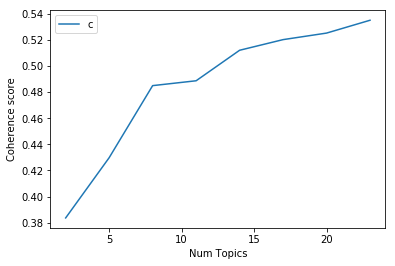

In [13]:
# Show graph
limit=26; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 10 topics itself.

In [14]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3837
Num Topics = 5  has Coherence Value of 0.4298
Num Topics = 8  has Coherence Value of 0.485
Num Topics = 11  has Coherence Value of 0.4887
Num Topics = 14  has Coherence Value of 0.512
Num Topics = 17  has Coherence Value of 0.5202
Num Topics = 20  has Coherence Value of 0.5252
Num Topics = 23  has Coherence Value of 0.535


### Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [15]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

We can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"say" + 0.014*"state" + 0.011*"case" + 0.010*"court" + 0.010*"law" + '
  '0.009*"report" + 0.008*"federal" + 0.007*"school" + 0.007*"department" + '
  '0.006*"student"'),
 (1,
  '0.018*"say" + 0.014*"go" + 0.013*"get" + 0.011*"people" + 0.011*"make" + '
  '0.010*"know" + 0.009*"time" + 0.009*"think" + 0.008*"want" + 0.007*"would"'),
 (2,
  '0.045*"trump" + 0.024*"president" + 0.022*"say" + 0.013*"house" + '
  '0.013*"would" + 0.010*"obama" + 0.010*"republican" + 0.007*"administration" '
  '+ 0.007*"white" + 0.006*"bill"'),
 (3,
  '0.011*"play" + 0.011*"game" + 0.009*"show" + 0.008*"team" + 0.008*"year" + '
  '0.007*"film" + 0.007*"season" + 0.007*"first" + 0.006*"good" + '
  '0.006*"last"'),
 (4,
  '0.009*"water" + 0.007*"study" + 0.007*"new" + 0.006*"food" + 0.005*"year" + '
  '0.005*"find" + 0.005*"scientist" + 0.005*"human" + 0.005*"could" + '
  '0.004*"science"'),
 (5,
  '0.037*"say" + 0.014*"police" + 0.012*"city" + 0.007*"people" + 0.007*"man" '
  '+ 0.007*"officer"

Topic 0 is a represented as _0.014"say" + 0.014"state" + 0.011"case" + 0.010"court" + 0.010"law" + 
  0.009"report" + 0.008"federal" + 0.007"school" + 0.007"department" + 0.006"student".

It means the top 10 keywords that contribute to this topic are: ‘say’, ‘state’, ‘case’.. and so on and the weight of ‘state’ on topic 0 is 0.014.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, we can guess what this topic could be, we may summarise the topic as 'law case about school'.

Likewise, we go through the remaining topic keywords and judge what the topic is.

### Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df.content.tolist(), dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.410405532036343

Coherence Score:  0.4731350614252297


### Visualize the topics-keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.035678  0.031274       1        1  23.009182
2     -0.163380  0.060712       2        1  11.502200
6     -0.087669 -0.117696       3        1  10.655497
9     -0.004979 -0.059894       4        1  10.195816
5      0.045394  0.104502       5        1   9.746809
0     -0.132358 -0.060003       6        1   9.388058
8     -0.067589  0.146088       7        1   7.464548
3      0.258703  0.195981       8        1   6.398067
7     -0.122480 -0.045709       9        1   6.279865
4      0.238679 -0.255255      10        1   5.359956, topic_info=     Category           Freq            Term          Total  loglift  logprob
term                                                                         
153   Default  140688.000000           trump  140688.000000  30.0000  30.0000
127   Default  247692.000000             say  247692.000000  29.0000  29.0000
324   Default   52514.000000       president   52514.000000  28.0000  28.0000
211   Default   23435.000000         clinton   23435.000000  27.0000  27.0000
2000  Default   34169.000000      republican   34169.000000  26.0000  26.0000
1005  Default   25753.000000         company   25753.000000  25.0000  25.0000
1397  Default   51054.000000           state   51054.000000  24.0000  24.0000
23    Default   27443.000000        campaign   27443.000000  23.0000  23.0000
2806  Default   21063.000000          police   21063.000000  22.0000  22.0000
1372  Default   28261.000000         percent   28261.000000  21.0000  21.0000
66    Default   28882.000000           house   28882.000000  20.0000  20.0000
48    Default   21890.000000        election   21890.000000  19.0000  19.0000
267   Default   65427.000000              go   65427.000000  18.0000  18.0000
385   Default   20509.000000            vote   20509.000000  17.0000  17.0000
414   Default   34355.000000        american   34355.000000  16.0000  16.0000
2405  Default   20957.000000            city   20957.000000  15.0000  15.0000
35    Default   33816.000000         country   33816.000000  14.0000  14.0000
145   Default   37965.000000           think   37965.000000  13.0000  13.0000
204   Default   13662.000000       candidate   13662.000000  12.0000  12.0000
1940  Default   21137.000000           party   21137.000000  11.0000  11.0000
1661  Default   21146.000000          attack   21146.000000  10.0000  10.0000
1515  Default   21394.000000           obama   21394.000000   9.0000   9.0000
2417  Default   14953.000000           court   14953.000000   8.0000   8.0000
1300  Default   20385.000000            case   20385.000000   7.0000   7.0000
265   Default   57327.000000             get   57327.000000   6.0000   6.0000
288   Default   20453.000000             law   20453.000000   5.0000   5.0000
80    Default   27799.000000             man   27799.000000   4.0000   4.0000
1275  Default   12003.000000           voter   12003.000000   3.0000   3.0000
144   Default   24940.000000           thing   24940.000000   2.0000   2.0000
1086  Default   15546.000000            play   15546.000000   1.0000   1.0000
...       ...            ...             ...            ...      ...      ...
1796  Topic10    5057.980469            food    6054.682617   2.7463  -5.1068
5271  Topic10    1396.529053           stone    1506.014160   2.8507  -6.3938
898   Topic10    3561.334961           space    4187.655762   2.7642  -5.4576
832   Topic10    1092.173950           robot    1159.755615   2.8662  -6.6396
3931  Topic10    2807.253906      researcher    3465.146729   2.7157  -5.6956
4719  Topic10    2668.386719             eat    3446.028076   2.6705  -5.7463
4703  Topic10    2086.472412         climate    2705.604736   2.6664  -5.9923
635   Topic10    3998.801514           human    6202.415039   2.4873  -5.3418
2277  Topic10    5698.181641           study   10387.867188   2.3257  -4.9876
2751  Topic10    1862.100098     

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

In [19]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df.content.tolist(), dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('trump', 0.03228543015140376),
   ('president', 0.017778307362450996),
   ('house', 0.010488024766576813),
   ('report', 0.009704888940848139),
   ('news', 0.009571493556178567),
   ('official', 0.007821615897732203),
   ('white', 0.007060962440206269),
   ('email', 0.006963538844661075),
   ('time', 0.005955579336905032),
   ('investigation', 0.005934595793249144)]),
 (1,
  [('company', 0.019753876298347513),
   ('percent', 0.013989509405930316),
   ('year', 0.01257148745427379),
   ('business', 0.00873190849298256),
   ('market', 0.007829111436992994),
   ('pay', 0.006531052296864895),
   ('job', 0.005895095597287917),
   ('price', 0.005509830414110088),
   ('deal', 0.0053583389149363695),
   ('money', 0.005126103215695442)]),
 (2,
  [('people', 0.009257628657611532),
   ('study', 0.008292282562860591),
   ('year', 0.007904528482960632),
   ('find', 0.007486885026068384),
   ('water', 0.005447137001594639),
   ('health', 0.005082809730688635),
   ('research', 0.0048743919127

Just by changing the LDA algorithm, we increased the coherence score from 0.47 to 0.49

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df.content.tolist()):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.content.tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1914,"make, woman, people, show, time, life, thing, ...","[ivanka, trump, trouble, convince, world, fath..."
1,1,1.0,0.3047,"american, people, policy, president, bill, hou...","[jar, regulatory, action, week, large, bank, b..."
2,2,2.0,0.5457,"make, company, facebook, time, year, system, w...","[tale, planet, begin, year, ago, planet, earth..."
3,3,0.0,0.6515,"make, woman, people, show, time, life, thing, ...","[british, costumer, sandy, powell, already, os..."
4,4,3.0,0.3391,"country, attack, government, military, war, st...","[king_salman, push, aside, crown_prince, nayef..."
5,5,6.0,0.6002,"percent, company, year, business, market, pay,...","[dollar, steady, monday, recover, friday, loss..."
6,6,3.0,0.1893,"country, attack, government, military, war, st...","[thursday, sovereign, citizen, temporarily, en..."
7,7,5.0,0.4234,"trump, president, news, house, report, white, ...","[may, avoid, criminal, charge, sear, rebuke, e..."
8,8,9.0,0.4120,"trump, republican, campaign, party, vote, clin...","[come, house, democrat, retreat, friday, heapi..."
9,9,5.0,0.3829,"trump, president, news, house, report, white, ...","[document, release, friday, federal, bureau, i..."


### Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7935,"make, woman, people, show, time, life, thing, ...","[reader, recommend, favorites_submit, especial..."
1,1.0,0.7667,"american, people, policy, president, bill, hou...","[republican, lose, seat, senate, house, lose, ..."
2,2.0,0.9084,"make, company, facebook, time, year, system, w...","[affaire_de, chaussett, valencienne, eclate, s..."
3,3.0,0.7781,"country, attack, government, military, war, st...","[istanbul, turkish, troop, tank, cross, syria,..."
4,4.0,0.9081,"game, team, year, play, time, make, good, back...","[still, olympic, champion, tonight, thank, rea..."
5,5.0,0.8062,"trump, president, news, house, report, white, ...","[former, acting, attorney_general, sally_yate,..."
6,6.0,0.8387,"percent, company, year, business, market, pay,...","[economic_growth, slow, fourth_quarter, sharpl..."
7,7.0,0.7681,"police, city, people, officer, man, kill, home...","[police, officer, shot, kill, sunday, apparent..."
8,8.0,0.8363,"school, people, child, study, student, find, y...","[gut, help, digest, food, bacteria, call, inte..."
9,9.0,0.7945,"trump, republican, campaign, party, vote, clin...","[hold, decisive, advantage, donald, trump, com..."


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

### Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [27]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"make, woman, people, show, time, life, thing, ...",5608.0,0.1311
1,1.0,"american, people, policy, president, bill, hou...",2784.0,0.0651
2,2.0,"make, company, facebook, time, year, system, w...",3143.0,0.0735
3,0.0,"make, woman, people, show, time, life, thing, ...",4905.0,0.1147
4,3.0,"country, attack, government, military, war, st...",2304.0,0.0539
5,6.0,"percent, company, year, business, market, pay,...",4036.0,0.0944
6,3.0,"country, attack, government, military, war, st...",3383.0,0.0791
7,5.0,"trump, president, news, house, report, white, ...",4695.0,0.1098
8,9.0,"trump, republican, campaign, party, vote, clin...",3146.0,0.0736
9,5.0,"trump, president, news, house, report, white, ...",5718.0,0.1337
